In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from itertools import islice
import statsmodels.api as sm
sns.set()
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

In [3]:
def parse_timestamp(el):
    b = datetime.datetime.strptime(el, fmt)
    return b

In [4]:
fmt = '%Y-%m-%d %H:%M:%S'

In [33]:
def trim_latlng(x):
    return round(x,4)

In [5]:
url = "/bigdata/jelicicna/mobility_data_2020/anlysis_data_nextbike_2020-07.csv"
df = pd.read_csv(url, sep=';', low_memory=False)

In [6]:
url2 = "/bigdata/jelicicna/clustering_datasets/locations_for_clustering_2020-07.csv"
df_locations = pd.read_csv(url2, sep=';', low_memory=False)

In [7]:
df['ride_begin'] = df['ride_begin'].map(parse_timestamp)
df['ride_end'] = df['ride_end'].map(parse_timestamp)

In [34]:
df['lat_begin'] = df['lat_begin'].map(trim_latlng)
df['lng_begin'] = df['lng_begin'].map(trim_latlng)
df['lat_end'] = df['lat_end'].map(trim_latlng)
df['lng_end'] = df['lng_end'].map(trim_latlng)

In [8]:
#adding tracking of original indexes for evaluation of results
df.reset_index(inplace=True)
df.rename({'index':'org_index'}, axis=1, inplace=True)

In [9]:
bikes = df[["name"]].drop_duplicates().reset_index(drop=True)
bikes["bike_id"]=bikes.index
bikes = bikes[["bike_id", "name"]]
bikes.head() #df with 2 columns containing bike id and corresponding bike names

,bike_id,name
0,0,BIKE 21596
1,1,BIKE 22082
2,2,BIKE 22729
3,3,BIKE 21129
4,4,BIKE 22783


In [11]:
#adding bike id to df
df = pd.merge(df, bikes, on='name', how='outer')

In [13]:
df_locations

,loc_id,latlng,lat,lng
0,0,"[50.9375, 6.9983]",50.9375,6.9983
1,1,"[50.9248, 6.9829]",50.9248,6.9829
2,2,"[50.9267, 6.93]",50.9267,6.9300
3,3,"[50.9282, 6.9356]",50.9282,6.9356
4,4,"[50.9356, 6.9239]",50.9356,6.9239
5,5,"[50.9289, 6.9152]",50.9289,6.9152
6,6,"[50.9375, 6.9437]",50.9375,6.9437
7,7,"[50.9674, 6.959]",50.9674,6.9590
8,8,"[50.943, 6.9378]",50.9430,6.9378
9,9,"[50.9195, 6.9505]",50.9195,6.9505


## Deciding on an optimal number of clusters

### Elbow method

In [15]:
#separate data
x = df_locations.iloc[:,2:4]

In [16]:
x.head()

,lat,lng
0,50.9375,6.9983
1,50.9248,6.9829
2,50.9267,6.9300
3,50.9282,6.9356
4,50.9356,6.9239


In [13]:
potential_k = []
for k in range(10,170,10):
    potential_k.append(k)

In [14]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in potential_k:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

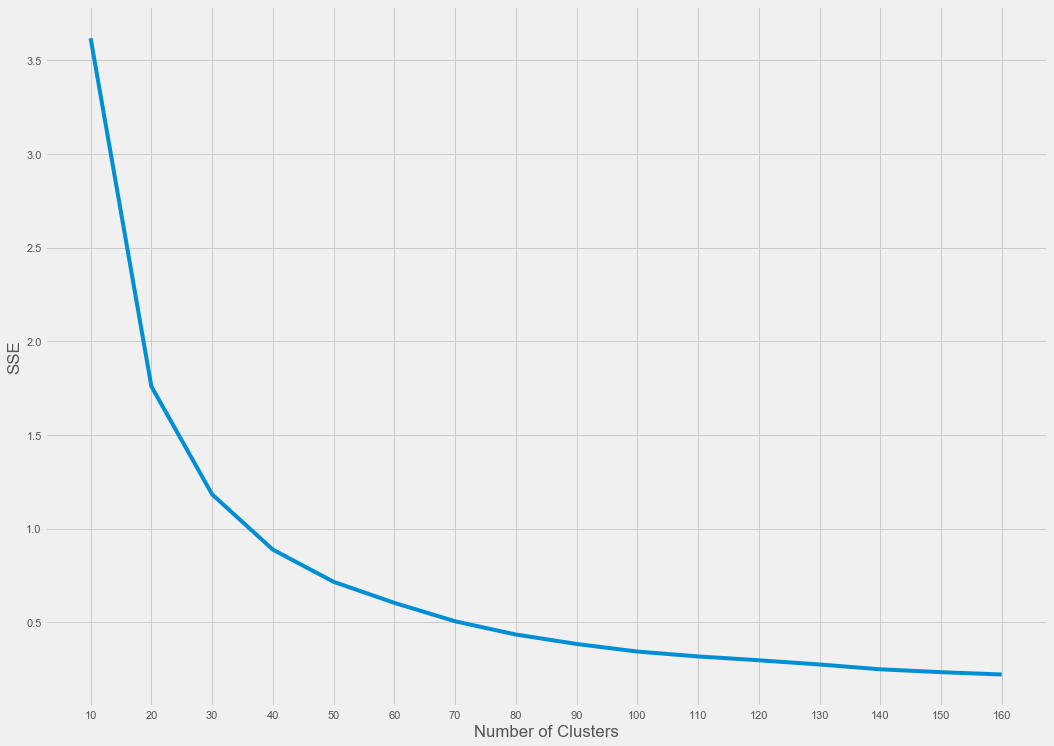

In [15]:
plt.style.use("fivethirtyeight")
plt.plot(potential_k, sse)
plt.xticks(potential_k)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [16]:
kl = KneeLocator(range(10,170,10), sse, curve="convex", direction="decreasing")
kl.elbow

40

In [19]:
#assigning the ideal result of the elbow method as a future k for clustering
clust_k = kl.elbow

### Silhouette coefficient

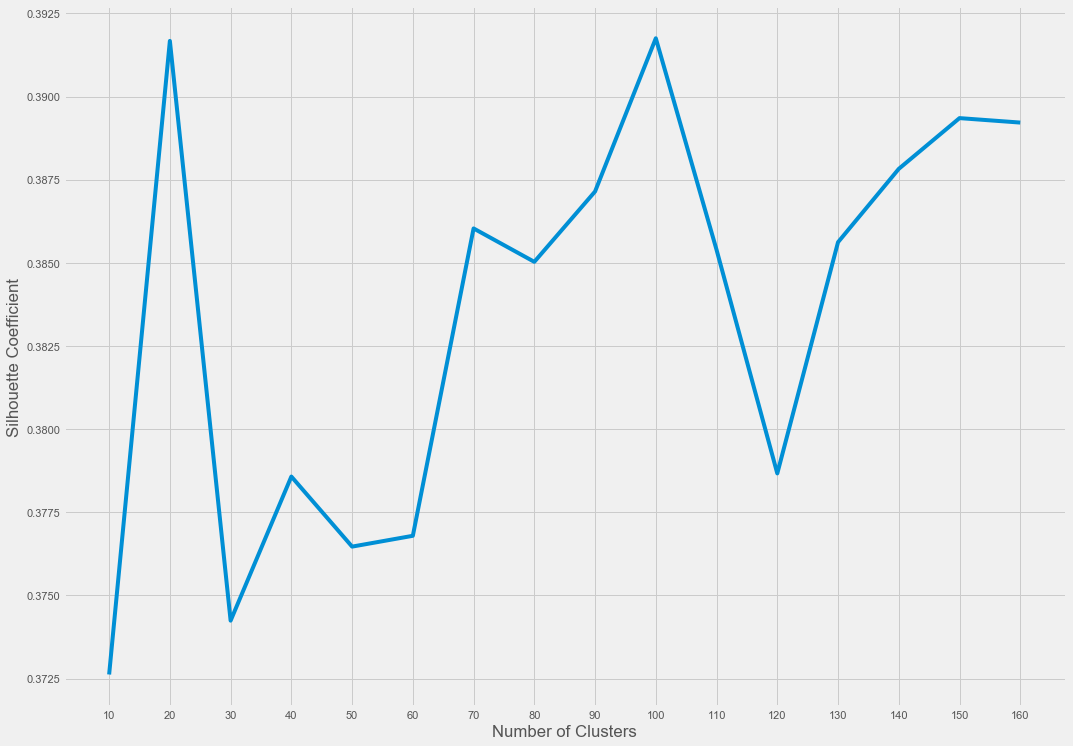

In [18]:
# A list with sc for each k to evalueate previous conclusion
silhouette_coefficients = []

for k in range(10, 170, 10):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(x)
    score = silhouette_score(x, kmeans.labels_)
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(10, 170, 10), silhouette_coefficients)
plt.xticks(range(10, 170, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Clustering

In [17]:
x = x.to_numpy()

In [20]:
kmeans = KMeans(clust_k)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=40, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [21]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([31,  9, 10, ..., 22, 38,  2], dtype=int32)

In [22]:
len(identified_clusters)

23804

In [23]:
df_locations['cluster'] = identified_clusters

In [24]:
df_locations.head(2)

,loc_id,latlng,lat,lng,cluster
0,0,"[50.9375, 6.9983]",50.9375,6.9983,31
1,1,"[50.9248, 6.9829]",50.9248,6.9829,9


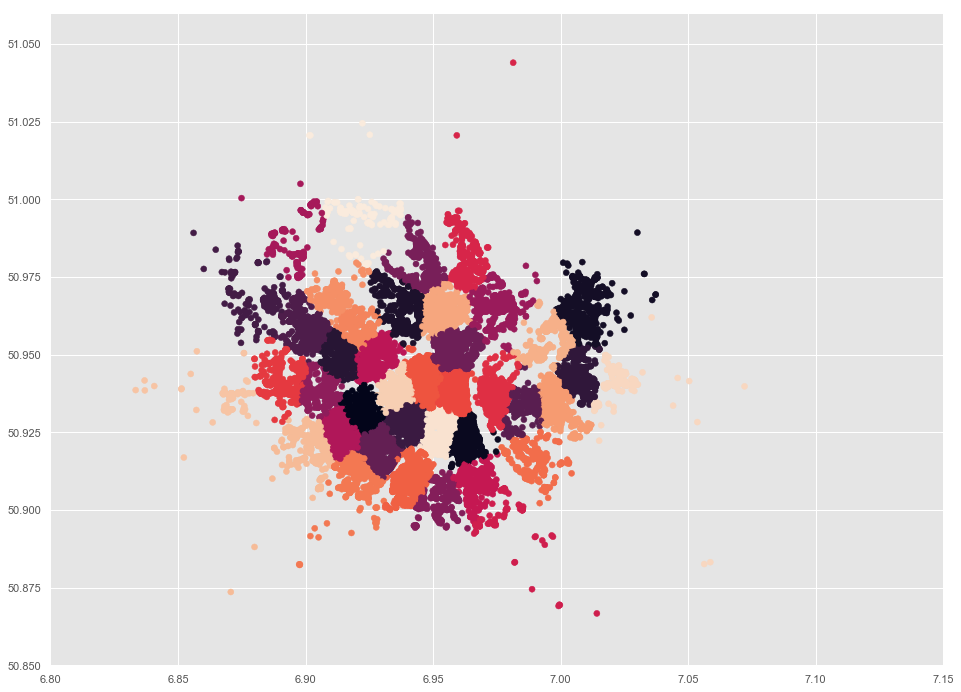

In [25]:
plt.scatter(df_locations['lng'],df_locations['lat'],c=df_locations['cluster'],cmap='rocket')
plt.xlim(6.80,7.15)
plt.ylim(50.85,51.06)
plt.show()

In [35]:
start_loc = []
for index, row in df.iterrows():
    loc_str = str([row['lat_begin'],row['lng_begin']])
    start_loc.append(loc_str)

In [36]:
end_loc = []
for index, row in df.iterrows():
    loc_str = str([row['lat_end'],row['lng_end']])
    end_loc.append(loc_str)

In [37]:
len(start_loc)

23670

In [38]:
len(end_loc)

23670

In [41]:
df

,org_index,old_index,lat_begin,lng_begin,lat_end,lng_end,ride_begin,ride_end,ride_time,distance,uid_begin,uid_end,standing_before_ride,name,available_bikes,calculated_distance,bike_id,latlng
0,0,12,50.9364,6.9252,50.9364,6.9204,2021-01-22 12:38:01,2021-01-22 12:44:01,6.0,339.0,41053864,41054855,31.0,BIKE 21596,788,4000.0,0,"[50.9364, 6.9252]"
1,1,13,50.9364,6.9204,50.9343,6.9473,2021-01-22 13:27:01,2021-01-22 13:42:02,15.0,1896.0,41054855,41056420,43.0,BIKE 21596,779,6500.0,0,"[50.9364, 6.9204]"
2,2,14,50.9343,6.9473,50.9365,6.9420,2021-01-22 13:45:01,2021-01-22 15:37:02,112.0,446.0,41056420,41059865,3.0,BIKE 21596,784,49000.0,0,"[50.9343, 6.9473]"
3,3,16,50.9365,6.9442,50.9367,6.9317,2021-01-23 09:42:01,2021-01-23 10:32:01,50.0,873.0,41067520,41078039,601.0,BIKE 21596,773,21500.0,0,"[50.9365, 6.9442]"
4,4,17,50.9367,6.9317,50.9436,6.9334,2021-01-23 10:34:01,2021-01-23 10:43:01,9.0,775.0,41078039,41078491,2.0,BIKE 21596,765,6500.0,0,"[50.9367, 6.9317]"
5,5,18,50.9436,6.9334,50.9570,6.9299,2021-01-23 11:06:02,2021-01-23 12:32:02,86.0,1507.0,41078491,41080265,23.0,BIKE 21596,767,36500.0,0,"[50.9436, 6.9334]"
6,6,19,50.9570,6.9299,50.9486,6.9188,2021-01-23 14:03:02,2021-01-23 14:28:02,25.0,1210.0,41080265,41082622,91.0,BIKE 21596,745,11500.0,0,"[50.957, 6.9299]"
7,7,21,50.9485,6.9189,50.9364,6.9286,2021-01-23 14:51:01,2021-01-23 15:17:01,26.0,1513.0,41083045,41084081,21.0,BIKE 21596,714,11500.0,0,"[50.9485, 6.9189]"
8,8,23,50.9362,6.9288,50.9270,6.9508,2021-01-26 15:56:01,2021-01-26 22:49:01,413.0,1852.0,41084350,41148838,4358.0,BIKE 21596,698,174000.0,0,"[50.9362, 6.9288]"
9,9,25,50.9274,6.9503,50.9005,6.9846,2021-01-29 15:04:02,2021-01-29 15:40:02,36.0,3837.0,41156807,41215741,3854.0,BIKE 21596,743,16500.0,0,"[50.9274, 6.9503]"


In [40]:
df['latlng'] = start_loc #setting starting locations as a joint column

In [42]:
df_merge_loc = df_locations[['loc_id', 'latlng', 'cluster']]

In [43]:
df_merge_loc

,loc_id,latlng,cluster
0,0,"[50.9375, 6.9983]",31
1,1,"[50.9248, 6.9829]",9
2,2,"[50.9267, 6.93]",10
3,3,"[50.9282, 6.9356]",6
4,4,"[50.9356, 6.9239]",0
5,5,"[50.9289, 6.9152]",17
6,6,"[50.9375, 6.9437]",25
7,7,"[50.9674, 6.959]",32
8,8,"[50.943, 6.9378]",36
9,9,"[50.9195, 6.9505]",38


In [51]:
df_clusters = pd.merge(df, df_merge_loc, on='latlng', how='left')

In [52]:
df_clusters

,org_index,old_index,lat_begin,lng_begin,lat_end,lng_end,ride_begin,ride_end,ride_time,distance,uid_begin,uid_end,standing_before_ride,name,available_bikes,calculated_distance,bike_id,latlng,loc_id,cluster
0,0,12,50.9364,6.9252,50.9364,6.9204,2021-01-22 12:38:01,2021-01-22 12:44:01,6.0,339.0,41053864,41054855,31.0,BIKE 21596,788,4000.0,0,"[50.9364, 6.9252]",10070.0,0.0
1,1,13,50.9364,6.9204,50.9343,6.9473,2021-01-22 13:27:01,2021-01-22 13:42:02,15.0,1896.0,41054855,41056420,43.0,BIKE 21596,779,6500.0,0,"[50.9364, 6.9204]",11396.0,0.0
2,2,14,50.9343,6.9473,50.9365,6.9420,2021-01-22 13:45:01,2021-01-22 15:37:02,112.0,446.0,41056420,41059865,3.0,BIKE 21596,784,49000.0,0,"[50.9343, 6.9473]",11642.0,25.0
3,3,16,50.9365,6.9442,50.9367,6.9317,2021-01-23 09:42:01,2021-01-23 10:32:01,50.0,873.0,41067520,41078039,601.0,BIKE 21596,773,21500.0,0,"[50.9365, 6.9442]",18987.0,25.0
4,4,17,50.9367,6.9317,50.9436,6.9334,2021-01-23 10:34:01,2021-01-23 10:43:01,9.0,775.0,41078039,41078491,2.0,BIKE 21596,765,6500.0,0,"[50.9367, 6.9317]",13105.0,36.0
5,5,18,50.9436,6.9334,50.9570,6.9299,2021-01-23 11:06:02,2021-01-23 12:32:02,86.0,1507.0,41078491,41080265,23.0,BIKE 21596,767,36500.0,0,"[50.9436, 6.9334]",18558.0,36.0
6,6,19,50.9570,6.9299,50.9486,6.9188,2021-01-23 14:03:02,2021-01-23 14:28:02,25.0,1210.0,41080265,41082622,91.0,BIKE 21596,745,11500.0,0,"[50.957, 6.9299]",18204.0,18.0
7,7,21,50.9485,6.9189,50.9364,6.9286,2021-01-23 14:51:01,2021-01-23 15:17:01,26.0,1513.0,41083045,41084081,21.0,BIKE 21596,714,11500.0,0,"[50.9485, 6.9189]",5078.0,4.0
8,8,23,50.9362,6.9288,50.9270,6.9508,2021-01-26 15:56:01,2021-01-26 22:49:01,413.0,1852.0,41084350,41148838,4358.0,BIKE 21596,698,174000.0,0,"[50.9362, 6.9288]",17606.0,36.0
9,9,25,50.9274,6.9503,50.9005,6.9846,2021-01-29 15:04:02,2021-01-29 15:40:02,36.0,3837.0,41156807,41215741,3854.0,BIKE 21596,743,16500.0,0,"[50.9274, 6.9503]",11514.0,38.0


In [53]:
cls = {'latlng':'latlng_start','loc_id':'loc_id_start', 'cluster':'cluster_start'}
df_clusters.rename(columns=cls, inplace=True) #renaming columns to match data about the start of the ride

In [55]:
len(df_clusters)

23670

In [56]:
df_clusters['latlng'] = end_loc #setting ending locations as a joint column

In [57]:
df_clusters = pd.merge(df_clusters, df_merge_loc, on='latlng', how='left')

In [58]:
df_clusters

,org_index,old_index,lat_begin,lng_begin,lat_end,lng_end,ride_begin,ride_end,ride_time,distance,...,name,available_bikes,calculated_distance,bike_id,latlng_start,loc_id_start,cluster_start,latlng,loc_id,cluster
0,0,12,50.9364,6.9252,50.9364,6.9204,2021-01-22 12:38:01,2021-01-22 12:44:01,6.0,339.0,...,BIKE 21596,788,4000.0,0,"[50.9364, 6.9252]",10070.0,0.0,"[50.9364, 6.9204]",11396.0,0.0
1,1,13,50.9364,6.9204,50.9343,6.9473,2021-01-22 13:27:01,2021-01-22 13:42:02,15.0,1896.0,...,BIKE 21596,779,6500.0,0,"[50.9364, 6.9204]",11396.0,0.0,"[50.9343, 6.9473]",11642.0,25.0
2,2,14,50.9343,6.9473,50.9365,6.9420,2021-01-22 13:45:01,2021-01-22 15:37:02,112.0,446.0,...,BIKE 21596,784,49000.0,0,"[50.9343, 6.9473]",11642.0,25.0,"[50.9365, 6.942]",5710.0,36.0
3,3,16,50.9365,6.9442,50.9367,6.9317,2021-01-23 09:42:01,2021-01-23 10:32:01,50.0,873.0,...,BIKE 21596,773,21500.0,0,"[50.9365, 6.9442]",18987.0,25.0,"[50.9367, 6.9317]",13105.0,36.0
4,4,17,50.9367,6.9317,50.9436,6.9334,2021-01-23 10:34:01,2021-01-23 10:43:01,9.0,775.0,...,BIKE 21596,765,6500.0,0,"[50.9367, 6.9317]",13105.0,36.0,"[50.9436, 6.9334]",18558.0,36.0
5,5,18,50.9436,6.9334,50.9570,6.9299,2021-01-23 11:06:02,2021-01-23 12:32:02,86.0,1507.0,...,BIKE 21596,767,36500.0,0,"[50.9436, 6.9334]",18558.0,36.0,"[50.957, 6.9299]",18204.0,18.0
6,6,19,50.9570,6.9299,50.9486,6.9188,2021-01-23 14:03:02,2021-01-23 14:28:02,25.0,1210.0,...,BIKE 21596,745,11500.0,0,"[50.957, 6.9299]",18204.0,18.0,"[50.9486, 6.9188]",13484.0,4.0
7,7,21,50.9485,6.9189,50.9364,6.9286,2021-01-23 14:51:01,2021-01-23 15:17:01,26.0,1513.0,...,BIKE 21596,714,11500.0,0,"[50.9485, 6.9189]",5078.0,4.0,"[50.9364, 6.9286]",18470.0,36.0
8,8,23,50.9362,6.9288,50.9270,6.9508,2021-01-26 15:56:01,2021-01-26 22:49:01,413.0,1852.0,...,BIKE 21596,698,174000.0,0,"[50.9362, 6.9288]",17606.0,36.0,"[50.927, 6.9508]",13143.0,38.0
9,9,25,50.9274,6.9503,50.9005,6.9846,2021-01-29 15:04:02,2021-01-29 15:40:02,36.0,3837.0,...,BIKE 21596,743,16500.0,0,"[50.9274, 6.9503]",11514.0,38.0,"[50.9005, 6.9846]",19033.0,20.0


In [59]:
cls = {'latlng':'latlng_end','loc_id':'loc_id_end', 'cluster':'cluster_end'}
df_clusters.rename(columns=cls, inplace=True) #renaming columns to match data about the start of the ride

In [60]:
df_g = df_clusters[['ride_time','cluster_start','cluster_end']]

In [61]:
df_g = df_g.groupby(['cluster_start','cluster_end']).count()

In [62]:
df_g.reset_index(inplace=True)

In [63]:
df_g.rename({'ride_time':'ride_count'}, axis=1, inplace=True)
df_g

,cluster_start,cluster_end,ride_count
0,0.0,0.0,97
1,0.0,1.0,9
2,0.0,3.0,9
3,0.0,4.0,40
4,0.0,6.0,83
5,0.0,8.0,20
6,0.0,9.0,5
7,0.0,10.0,93
8,0.0,11.0,17
9,0.0,13.0,4


In [64]:
df_g['cluster_start'].value_counts()

24.0    39
25.0    39
36.0    38
11.0    38
18.0    37
38.0    36
6.0     35
8.0     35
10.0    35
32.0    35
17.0    33
4.0     33
3.0     33
22.0    33
1.0     33
26.0    32
19.0    32
29.0    31
23.0    31
2.0     30
14.0    30
15.0    30
0.0     30
12.0    29
28.0    29
33.0    28
9.0     26
34.0    26
31.0    26
30.0    25
13.0    25
5.0     25
21.0    24
20.0    22
27.0    21
39.0    20
7.0     20
35.0    19
16.0    19
37.0    16
Name: cluster_start, dtype: int64

In [33]:
df_locations.rename({'cluster':'cluster_kmns'}, inplace=True, axis=1)

In [34]:
df_locations.head()

,loc_id,latlng,lat,lng,cluster_kmns
0,0,"[50.9161, 6.9803]",50.9161,6.9803,29
1,1,"[50.9458, 6.9467]",50.9458,6.9467,23
2,2,"[50.953, 6.9375]",50.9530,6.9375,18
3,3,"[50.9412, 6.9298]",50.9412,6.9298,7
4,4,"[50.9184, 6.969]",50.9184,6.9690,31


### Agglomerative Clustering with chosen k

In [67]:
len(x)

23804

In [68]:
from sklearn.cluster import AgglomerativeClustering

In [69]:
clustering = AgglomerativeClustering(clust_k).fit(x)
clustering

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=40)

In [70]:
clustering.labels_

array([ 6, 23, 38, ..., 17, 22, 28])

In [76]:
df_locations['cluster_agg'] = clustering.labels_

In [31]:
df_locations

,loc_id,latlng,lat,lng,cluster
0,0,"[50.9161, 6.9803]",50.9161,6.9803,29
1,1,"[50.9458, 6.9467]",50.9458,6.9467,23
2,2,"[50.953, 6.9375]",50.9530,6.9375,18
3,3,"[50.9412, 6.9298]",50.9412,6.9298,7
4,4,"[50.9184, 6.969]",50.9184,6.9690,31
5,5,"[50.936, 6.8698]",50.9360,6.8698,22
6,6,"[50.9316, 6.926]",50.9316,6.9260,19
7,7,"[50.9514, 6.9119]",50.9514,6.9119,5
8,8,"[50.922, 6.9589]",50.9220,6.9589,33
9,9,"[50.9085, 6.9398]",50.9085,6.9398,20


In [30]:
plt.scatter(df_locations['lng'],df_locations['lat'],c=df_locations['cluster_agg'],cmap='rocket')
plt.xlim(6.80,7.15)
plt.ylim(50.85,51.05)
plt.show()

KeyError: 'cluster_agg'

In [77]:
df_locations.head(20)

,loc_id,latlng,lat,lng,cluster_kmns,cluster_agg
0,0,"[50.9375, 6.9983]",50.9375,6.9983,31,6
1,1,"[50.9248, 6.9829]",50.9248,6.9829,9,23
2,2,"[50.9267, 6.93]",50.9267,6.9300,10,38
3,3,"[50.9282, 6.9356]",50.9282,6.9356,6,22
4,4,"[50.9356, 6.9239]",50.9356,6.9239,0,18
5,5,"[50.9289, 6.9152]",50.9289,6.9152,17,14
6,6,"[50.9375, 6.9437]",50.9375,6.9437,25,11
7,7,"[50.9674, 6.959]",50.9674,6.9590,32,24
8,8,"[50.943, 6.9378]",50.9430,6.9378,36,27
9,9,"[50.9195, 6.9505]",50.9195,6.9505,38,7


In [80]:
type(df_locations['latlng'])

pandas.core.series.Series

In [71]:
len(df_locations)

23804

In [72]:
df_locations['cluster_kmns'].value_counts(dropna=False)

10    1120
6     1065
24    1000
36     956
18     919
4      900
17     894
31     880
11     857
32     854
26     838
22     822
2      809
25     786
1      744
8      739
0      736
5      714
38     702
3      589
19     572
28     518
15     472
12     446
29     442
14     441
21     433
33     432
9      430
23     414
34     389
13     358
27     320
30     253
37     218
7      203
16     183
39     160
20     119
35      77
Name: cluster_kmns, dtype: int64

In [78]:
df_locations['cluster_agg'].value_counts(dropna=False)

7     1332
0     1240
22    1113
27    1101
8     1013
6      970
14     964
13     942
12     873
17     857
24     838
3      832
4      809
1      762
10     757
11     681
2      666
28     564
38     557
18     541
25     508
15     498
36     491
31     471
5      462
9      449
32     435
33     423
23     330
30     309
20     293
35     286
16     278
29     244
21     200
26     183
34     159
19     155
39     143
37      75
Name: cluster_agg, dtype: int64